# <a title="Activity Recognition" href="https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition" > LSTMs for Human Activity Recognition</a>

Human Activity Recognition (HAR) using smartphones dataset and an LSTM RNN. Classifying the type of movement amongst six categories:
- WALKING,
- WALKING_UPSTAIRS,
- WALKING_DOWNSTAIRS,
- SITTING,
- STANDING,
- LAYING.

Compared to a classical approach, using a Recurrent Neural Networks (RNN) with Long Short-Term Memory cells (LSTMs) require no or almost no feature engineering. Data can be fed directly into the neural network who acts like a black box, modeling the problem correctly. [Other research](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names) on the activity recognition dataset can use a big amount of feature engineering, which is rather a signal processing approach combined with classical data science techniques. The approach here is rather very simple in terms of how much was the data preprocessed. 

Let's use Google's neat Deep Learning library, TensorFlow, demonstrating the usage of an LSTM, a type of Artificial Neural Network that can process sequential data / time series. 

## Video dataset overview

Follow this link to see a video of the 6 activities recorded in the experiment with one of the participants:

<p align="center">
  <a href="http://www.youtube.com/watch?feature=player_embedded&v=XOEN9W05_4A
" target="_blank"><img src="http://img.youtube.com/vi/XOEN9W05_4A/0.jpg" 
alt="Video of the experiment" width="400" height="300" border="10" /></a>
  <a href="https://youtu.be/XOEN9W05_4A"><center>[Watch video]</center></a>
</p>

## Details about the input data

I will be using an LSTM on the data to learn (as a cellphone attached on the waist) to recognise the type of activity that the user is doing. The dataset's description goes like this:

> The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window). The sensor acceleration signal, which has gravitational and body motion components, was separated using a Butterworth low-pass filter into body acceleration and gravity. The gravitational force is assumed to have only low frequency components, therefore a filter with 0.3 Hz cutoff frequency was used. 

That said, I will use the almost raw data: only the gravity effect has been filtered out of the accelerometer  as a preprocessing step for another 3D feature as an input to help learning. If you'd ever want to extract the gravity by yourself, you could fork my code on using a [Butterworth Low-Pass Filter (LPF) in Python](https://github.com/guillaume-chevalier/filtering-stft-and-laplace-transform) and edit it to have the right cutoff frequency of 0.3 Hz which is a good frequency for activity recognition from body sensors.

## What is an RNN?

As explained in [this article](http://karpathy.github.io/2015/05/21/rnn-effectiveness/), an RNN takes many input vectors to process them and output other vectors. It can be roughly pictured like in the image below, imagining each rectangle has a vectorial depth and other special hidden quirks in the image below. **In our case, the "many to one" architecture is used**: we accept time series of [feature vectors](https://www.quora.com/What-do-samples-features-time-steps-mean-in-LSTM/answer/Guillaume-Chevalier-2) (one vector per [time step](https://www.quora.com/What-do-samples-features-time-steps-mean-in-LSTM/answer/Guillaume-Chevalier-2)) to convert them to a probability vector at the output for classification. Note that a "one to one" architecture would be a standard feedforward neural network. 

> <a href="https://www.dl-rnn-course.neuraxio.com/start?utm_source=github_lstm" ><img src="https://raw.githubusercontent.com/Neuraxio/Machine-Learning-Figures/master/rnn-architectures.png" /></a>
> [Learn more on RNNs](https://www.dl-rnn-course.neuraxio.com/start?utm_source=github_lstm)

## What is an LSTM?

An LSTM is an improved RNN. It is more complex, but easier to train, avoiding what is called the vanishing gradient problem. I recommend [this course](https://www.dl-rnn-course.neuraxio.com/start?utm_source=github_lstm) for you to learn more on LSTMs.

> [Learn more on LSTMs](https://www.dl-rnn-course.neuraxio.com/start?utm_source=github_lstm)


## Results 

Scroll on! Nice visuals awaits. 

In [1]:
# All Includes

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from tensorflow.keras.utils import to_categorical
from sklearn import metrics

import os

In [2]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    # "body_acc_x_",
    # "body_acc_y_",
    # "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    # "total_acc_x_",
    # "total_acc_y_",
    # "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]


## Let's start by downloading the data: 

In [3]:
# Note: Linux bash commands start with a "!" inside those "ipython notebook" cells

DATA_PATH = "data/"

!pwd && ls
os.chdir(DATA_PATH)
!pwd && ls

!python download_dataset.py

!pwd && ls
os.chdir("..")
!pwd && ls

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)


'pwd' is not recognized as an internal or external command,
operable program or batch file.
'pwd' is not recognized as an internal or external command,
operable program or batch file.



Downloading...
Dataset already downloaded. Did not download twice.

Extracting...
Dataset already extracted. Did not extract twice.



'pwd' is not recognized as an internal or external command,
operable program or batch file.



Dataset is now located at: data/UCI HAR Dataset/


'pwd' is not recognized as an internal or external command,
operable program or batch file.


## Preparing dataset:

In [4]:
TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []

    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()

    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()

    # Substract 1 to each output class for friendly 0-based indexing
    return y_ - 1

y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


## Additionnal Parameters:

Here are some core parameter definitions for the training. 

For example, the whole neural network's structure could be summarised by enumerating those parameters and the fact that two LSTM are used one on top of another (stacked) output-to-input as hidden layers through time steps. 

In [5]:
# Input Data

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 128 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Training

learning_rate = 0.0001
lambda_loss_amount = 0.0015
training_iters = training_data_count * 300  # Loop 300 times on the dataset
batch_size = 1000
display_iter = 30000  # To show test set accuracy during training


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")


Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 3) (2947, 1) -0.0029600263 0.33441213
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


## Utility functions for training:

In [6]:
def LSTM_RNN(input_shape, n_classes, n_hidden):
    """
    TensorFlow 2.x 스타일의 LSTM RNN 모델 정의
    input_shape: (타임 스텝, 입력 특성 수)
    n_classes: 출력 클래스 수
    n_hidden: LSTM 셀의 뉴런 수
    """
    model = tf.keras.Sequential()

    # 첫 번째 LSTM 레이어
    model.add(tf.keras.layers.LSTM(n_hidden, return_sequences=True,
                                   input_shape=input_shape))
    model.add(tf.keras.layers.Dropout(0.4))

    # 두 번째 LSTM 레이어
    model.add(tf.keras.layers.LSTM(n_hidden))

    # Dense 레이어 (출력층 전)
    model.add(tf.keras.layers.Dense(n_hidden, activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(0.001))) # L2 정규화 추가
    model.add(tf.keras.layers.BatchNormalization())  # 배치 정규화 추가
    model.add(tf.keras.layers.Dropout(0.4))

    # 출력층
    model.add(tf.keras.layers.Dense(n_classes, activation='softmax'))

    # 모델 컴파일
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# y_train과 y_test에 원-핫 인코딩 적용
y_train = to_categorical(y_train, num_classes=n_classes)
y_test = to_categorical(y_test, num_classes=n_classes)

# 배치 데이터를 추출하는 함수
def extract_batch_size(data, step, batch_size):
    """배치 데이터를 추출하는 함수"""
    start_index = (step - 1) * batch_size
    end_index = start_index + batch_size

    # 데이터가 끝까지 도달했을 경우 남은 데이터만 추출
    if end_index > len(data):
        end_index = len(data)

    batch_s = data[start_index:end_index]
    
    return batch_s


## Let's get serious and build the neural network:

In [7]:
# Graph weights
weights = {
    'hidden': tf.Variable(tf.random.normal([n_input, n_hidden])),  # Hidden layer weights
    'out': tf.Variable(tf.random.normal([n_hidden, n_classes], mean=1.0))
}

biases = {
    'hidden': tf.Variable(tf.random.normal([n_hidden])),
    'out': tf.Variable(tf.random.normal([n_classes]))
}

input_shape=(X_train.shape[1], 3)  # 입력 데이터의 형태

# LSTM 모델 생성
model = LSTM_RNN(input_shape, n_classes, n_hidden)

# 모델 훈련
history = model.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_test, y_test))

# # 모델 학습이 끝난 후 모델을 저장
# model.save('LSTM_model(Gyro_3axis).h5')  # 모델을 h5 파일로 저장
# print("모델이 저장되었습니다: LSTM_model(Gyro_3axis).h5")

# 모델 평가
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc}')

Epoch 1/200
115/115 [==============================] - 19s 133ms/step - loss: 1.3670 - accuracy: 0.4217 - val_loss: 1.5545 - val_accuracy: 0.5025
Epoch 2/200
115/115 [==============================] - 14s 123ms/step - loss: 1.0598 - accuracy: 0.5437 - val_loss: 1.1787 - val_accuracy: 0.5490
Epoch 3/200
115/115 [==============================] - 14s 126ms/step - loss: 0.9031 - accuracy: 0.5890 - val_loss: 1.0623 - val_accuracy: 0.5382
Epoch 4/200
115/115 [==============================] - 14s 123ms/step - loss: 0.8503 - accuracy: 0.6047 - val_loss: 1.0653 - val_accuracy: 0.5484
Epoch 5/200
115/115 [==============================] - 14s 124ms/step - loss: 0.8061 - accuracy: 0.6136 - val_loss: 0.9084 - val_accuracy: 0.5928
Epoch 6/200
115/115 [==============================] - 14s 124ms/step - loss: 0.6317 - accuracy: 0.6831 - val_loss: 0.8394 - val_accuracy: 0.6963
Epoch 16/200
115/115 [==============================] - 14s 124ms/step - loss: 0.6514 - accuracy: 0.6680 - val_loss: 0.8600 

## Hooray, now train the neural network:

In [8]:
# To keep track of training's performance
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []

# Perform Training steps with "batch_size" amount of example data at each loop
# 훈련 과정
step = 1
training_iters = 3000  # 예시로 임의 설정
batch_size = 64
display_iter = 300  # 몇 번의 반복마다 출력할지 설정

while step * batch_size <= training_iters:
    batch_xs = extract_batch_size(X_train, step, batch_size)
    batch_ys = extract_batch_size(y_train, step, batch_size)  # 이미 원-핫 인코딩된 y_train 사용

    # 배치 데이터를 사용해 훈련
    history = model.fit(
        batch_xs,
        batch_ys,
        epochs=1,  # 이미 배치별로 처리되고 있으므로 1 에포크만 실행
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        verbose=0
    )

    # 훈련 손실 및 정확도 출력
    loss = history.history['loss'][0]
    acc = history.history['accuracy'][0]
    print(f"Training iter #{step * batch_size}: Batch Loss = {loss:.6f}, Accuracy = {acc:.6f}")

    # 테스트 손실 및 정확도 계산
    if step * batch_size % display_iter == 0:
        test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
        print(f"PERFORMANCE ON TEST SET: Batch Loss = {test_loss:.6f}, Accuracy = {test_acc:.6f}")

    step += 1

print("Optimization Finished!")

# Accuracy for test data

# 모델 평가를 위한 수정된 코드
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"FINAL RESULT: Test Loss = {test_loss:.6f}, Accuracy = {test_acc:.6f}")

# 예측값 구하기
one_hot_predictions = model.predict(X_test)

# 예측값의 최대값 인덱스 가져오기
predictions = one_hot_predictions.argmax(axis=1)

# 최종 성능 출력
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Training iter #64: Batch Loss = 0.116421, Accuracy = 0.968750
Training iter #128: Batch Loss = 0.205517, Accuracy = 0.953125
Training iter #192: Batch Loss = 0.070190, Accuracy = 0.968750
Training iter #256: Batch Loss = 0.035762, Accuracy = 0.984375
Training iter #320: Batch Loss = 0.336879, Accuracy = 0.921875
Training iter #384: Batch Loss = 0.121441, Accuracy = 0.953125
Training iter #448: Batch Loss = 0.121265, Accuracy = 0.937500
Training iter #512: Batch Loss = 0.404590, Accuracy = 0.859375
Training iter #576: Batch Loss = 0.382770, Accuracy = 0.875000
Training iter #640: Batch Loss = 0.264013, Accuracy = 0.921875
Training iter #704: Batch Loss = 0.033792, Accuracy = 0.984375
Training iter #768: Batch Loss = 0.147992, Accuracy = 0.968750
Training iter #832: Batch Loss = 0.266703, Accuracy = 0.921875
Training iter #896: Batch Loss = 0.192583, Accuracy = 0.937500
Training iter #960: Batch Loss = 0.535101, Accuracy = 0.890625
Training iter #1024: Batch Loss = 0.255198, Accuracy = 0

## Training is good, but having visual insight is even better:

Okay, let's plot this simply in the notebook for now.

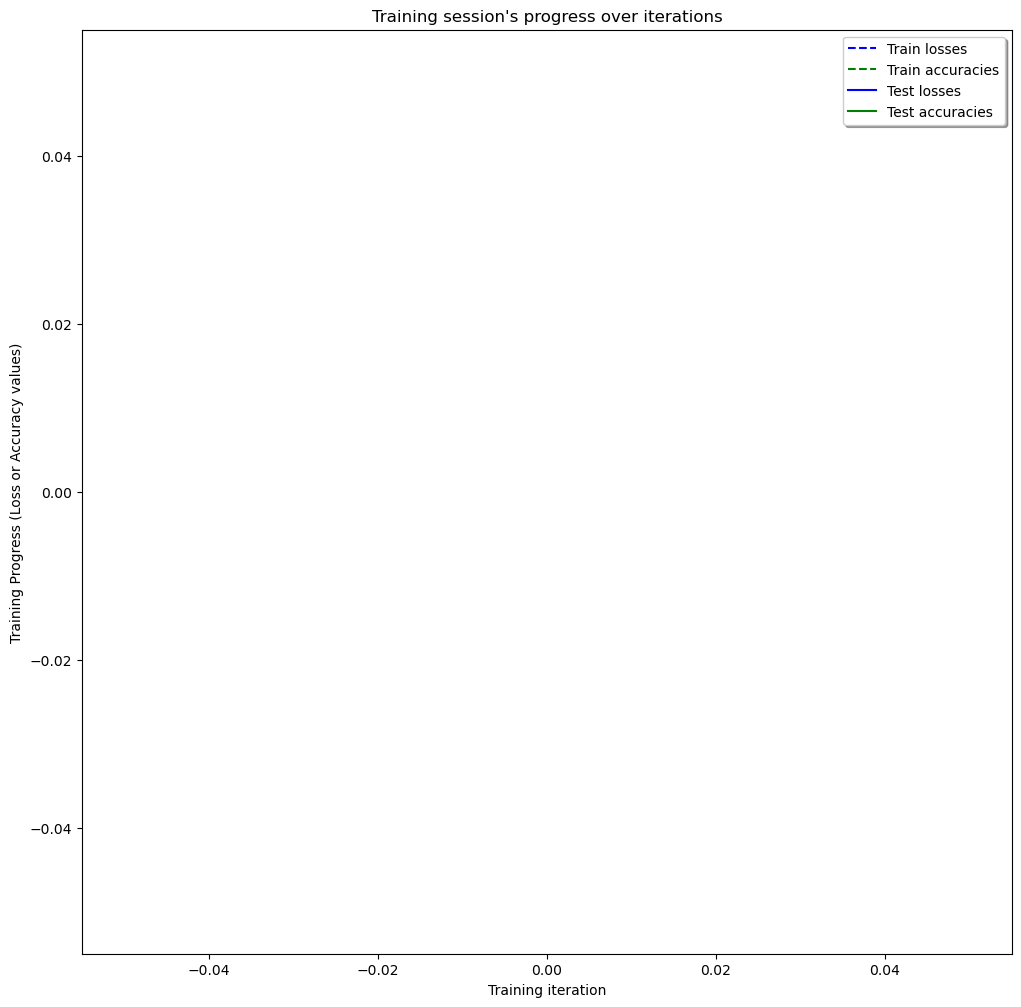

In [9]:
# (Inline plots: )
%matplotlib inline

# matplotlib 폰트 설정을 기본 값으로 설정
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

# 플롯 사이즈 설정
width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses), "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

# Test data plotting
indep_test_axis = np.array(range(batch_size, len(test_losses)*display_iter, display_iter))
plt.plot(indep_test_axis, np.array(test_losses), "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')

plt.show()


## And finally, the multi-class confusion matrix and metrics!

In [10]:
# Results

predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

print("")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)
print("Note: training and testing data is not equally distributed amongst classes, ")
print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")

# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

NameError: name 'accuracy' is not defined

## Conclusion

Outstandingly, **the final accuracy is of 91%**! And it can peak to values such as 93.25%, at some moments of luck during the training, depending on how the neural network's weights got initialized at the start of the training, randomly. 

This means that the neural networks is almost always able to correctly identify the movement type! Remember, the phone is attached on the waist and each series to classify has just a 128 sample window of two internal sensors (a.k.a. 2.56 seconds at 50 FPS), so it amazes me how those predictions are extremely accurate given this small window of context and raw data. I've validated and re-validated that there is no important bug, and the community used and tried this code a lot. (Note: be sure to report something in the issue tab if you find bugs, otherwise [Quora](https://www.quora.com/), [StackOverflow](https://stackoverflow.com/questions/tagged/tensorflow?sort=votes&pageSize=50), and other [StackExchange](https://stackexchange.com/sites#science) sites are the places for asking questions.)

I specially did not expect such good results for guessing between the labels "SITTING" and "STANDING". Those are seemingly almost the same thing from the point of view of a device placed at waist level according to how the dataset was originally gathered. Thought, it is still possible to see a little cluster on the matrix between those classes, which drifts away just a bit from the identity. This is great.

It is also possible to see that there was a slight difficulty in doing the difference between "WALKING", "WALKING_UPSTAIRS" and "WALKING_DOWNSTAIRS". Obviously, those activities are quite similar in terms of movements. 

I also tried my code without the gyroscope, using only the 3D accelerometer's 6 features (and not changing the training hyperparameters), and got an accuracy of 87%. In general, gyroscopes consumes more power than accelerometers, so it is preferable to turn them off. 


## Improvements

In [another open-source repository of mine](https://github.com/guillaume-chevalier/HAR-stacked-residual-bidir-LSTMs), the accuracy is pushed up to nearly 94% using a special deep LSTM architecture which combines the concepts of bidirectional RNNs, residual connections, and stacked cells. This architecture is also tested on another similar activity dataset. It resembles the nice architecture used in "[Google’s Neural Machine Translation System: Bridging the Gap between Human and Machine Translation](https://arxiv.org/pdf/1609.08144.pdf)", without an attention mechanism, and with just the encoder part - as a "many to one" architecture instead of a "many to many" to be adapted to the Human Activity Recognition (HAR) problem. I also worked more on the problem and came up with the [LARNN](https://github.com/guillaume-chevalier/Linear-Attention-Recurrent-Neural-Network), however it's complicated for just a little gain. Thus the current, original activity recognition project is simply better to use for its outstanding simplicity. 

If you want to learn more about deep learning, I have also built a list of the learning ressources for deep learning which have revealed to be the most useful to me [here](https://github.com/guillaume-chevalier/Awesome-Deep-Learning-Resources). 


## References

The [dataset](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) can be found on the UCI Machine Learning Repository: 

> Davide Anguita, Alessandro Ghio, Luca Oneto, Xavier Parra and Jorge L. Reyes-Ortiz. A Public Domain Dataset for Human Activity Recognition Using Smartphones. 21th European Symposium on Artificial Neural Networks, Computational Intelligence and Machine Learning, ESANN 2013. Bruges, Belgium 24-26 April 2013.

## Citation

Copyright (c) 2016 Guillaume Chevalier. To cite my code, you can point to the URL of the GitHub repository, for example: 

> Guillaume Chevalier, LSTMs for Human Activity Recognition, 2016, 
> https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition

My code is available for free and even for private usage for anyone under the [MIT License](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition/blob/master/LICENSE), however I ask to cite for using the code. 

Here is the BibTeX citation code: 
```
@misc{chevalier2016lstms,
  title={LSTMs for human activity recognition},
  author={Chevalier, Guillaume},
  year={2016}
}
```

## Extra links

### Connect with me

- [LinkedIn](https://ca.linkedin.com/in/chevalierg)
- [Twitter](https://twitter.com/guillaume_che)
- [GitHub](https://github.com/guillaume-chevalier/)
- [Quora](https://www.quora.com/profile/Guillaume-Chevalier-2)
- [YouTube](https://www.youtube.com/c/GuillaumeChevalier)
- [Dev/Consulting](http://www.neuraxio.com/en/)

### Liked this project? Did it help you? Leave a [star](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition/stargazers), [fork](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition/network/members) and share the love!

This activity recognition project has been seen in:

- [Hacker News 1st page](https://news.ycombinator.com/item?id=13049143)
- [Awesome TensorFlow](https://github.com/jtoy/awesome-tensorflow#tutorials)
- [TensorFlow World](https://github.com/astorfi/TensorFlow-World#some-useful-tutorials)
- And more.

---


In [ ]:
# Let's convert this notebook to a README automatically for the GitHub project's title page:
!jupyter nbconvert --to markdown LSTM.ipynb
!mv LSTM.md README.md